Main database Link : 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [10]:
df = pd.read_csv('./data/ai4i2020.csv')

In [11]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [12]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [13]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000




```
# Ce texte est au format code
```

Let's first try to understand the data, and have a first look at the Tool Wear parameter. The tool wear is the number of consecutive minutes one tool has been used. When it goes down to 0 it means that the tool broke.

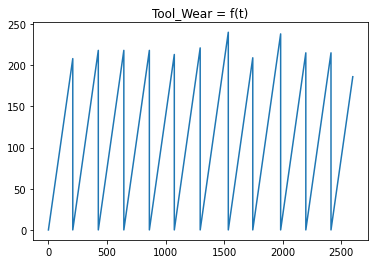

In [14]:
totalTime = [0]*10000
for i in range(1,10000):
  if df['Tool wear [min]'][i] == 0:
    totalTime[i] = totalTime[i-1]+df['Tool wear [min]'][i]
  else:
    totalTime[i] = totalTime[i-1] + df['Tool wear [min]'][i]-df['Tool wear [min]'][i-1]
#plt.plot(totalTime)
df['totalTime'] = totalTime

plt.figure()
plt.title("Tool_Wear = f(t)")
plt.plot([df['totalTime'][i] for i in range(1000)], df['Tool wear [min]'][:1000])

And if we take the problem in the other way around, we can compute and draw the number of days before the tool breaks:

[78, 1088, 1510, 1683, 1764, 1997, 2167, 2245, 2672, 2865, 2942, 3530, 3612, 3696, 3866, 4035, 4208, 4386, 4470, 4647, 4817, 5142, 5310, 5402, 5910, 6000, 6173, 6257, 6341, 6420, 6760, 7088, 7427, 7511, 7688, 7850, 8112, 8200, 8358, 8610, 8691, 8847, 9019, 9175, 9577, 9759]
78
1088
1510
1683
1764
1997
2167
2245
2672
2865
2942


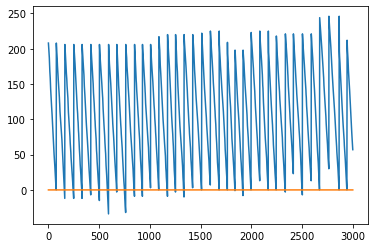

In [15]:
y = []

UDI_breaks = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    UDI_breaks.append(i);
print(UDI_breaks)
UDI_breaks_iterator = iter(UDI_breaks)
actual_break_UDI = next(UDI_breaks_iterator)

for i in range(3000):
  if i > actual_break_UDI:
    print(actual_break_UDI)
    actual_break_UDI = next(UDI_breaks_iterator)
  y.append(df['Tool wear [min]'][actual_break_UDI-1] - df['Tool wear [min]'][i])
  
plt.plot(y)
plt.plot([0]*3000)

Let's have a closer look at our distribution of failure point. Let's compute the mean interval between two tool failures and the variance of it:

Tool wear failure interval distribution
Mean:               216.3695652173913 min
Variance:           146.97211720226844 min
Standard Deviation:  12.123205731252293 min


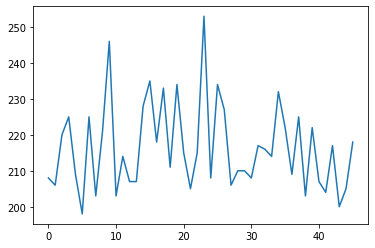

In [16]:
intervals_length = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    intervals_length.append(df['Tool wear [min]'][i-1])

plt.plot([i for i in range(len(intervals_length))], intervals_length)

intervals_length = np.array(intervals_length)
print("Tool wear failure interval distribution")
print("Mean:               {} min".format(np.mean(intervals_length)))
print("Variance:           {} min".format(np.var(intervals_length)))
print("Standard Deviation:  {} min".format(np.std(intervals_length)))


Let's create a dataset with cumulative data (First with the Torque and the Rpm only)

In [17]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'Failure':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Rpm'][i-1]
  if df['TWF'][i]==1:
    cumulative_df['Failure'][i]=1
  else:
    cumulative_df['Failure'][i]=0

  

In [18]:
cumulative_df.head(80)

,Torque,Rpm,ToolWear,Failure
0,128,4653,0,0
1,220,7469,3,0
2,318,10465,5,0
3,397,13331,7,0
4,477,16147,9,0
...,...,...,...,...
75,8179,317700,204,0
76,8274,320622,206,0
77,8274,320622,208,1
78,103,2796,0,0


Let's split in a training and test dataset:

In [19]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)
print(np.ravel(np.array(y_train)))

[0 0 0 ... 0 0 0]


Let's first try a Logistic regression on the cumulative torque and rpm to predict if there is a tool failure or not.

In [20]:
LR_model_1 = LogisticRegression(solver='liblinear', max_iter=2000)
LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

In [21]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)

LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

def predict_and_test(LR_model,X,y):
  y_hat = LR_model.predict(X)
  y = np.array(y)
  corrects = 0
  corrects_0 = 0
  count_1 = 0
  count_0 = 0
  for i in range(len(y)):
    if (y[i] == 1):
      count_1 += 1
      if(y_hat[i] == y[i]):
        corrects+=1
    if (y[i]==0):
      count_0 += 1
      if (y_hat[i] == y[i]):
        corrects_0 += 1
  print(count_1)
  return (corrects/count_1,corrects_0/count_0)


accuracy_training = predict_and_test(LR_model_1,X_test,y_test)
print(accuracy_training)
print(np.sum(np.array(y_test))/len(y_test))

26
(0.0, 1.0)
0.0065


We are not getting any results for now because there is way too many 0 compared to 1 in y_test. We should try to diminish the ratio 0/1 by only keeping the one just before the failure.

Let's add a column that compute the RUL to the dataframe in order to try the regression.

In [22]:
RUL = []

toolChanges = []
for i in range(1,10000):
  if df['Tool wear [min]'][i-1] == 0:
    toolChanges.append(i-2)
print(toolChanges)
iterator = iter(toolChanges)
actual = next(iterator)

for i in range(9999):
  if i > actual:
    actual = next(iterator,9999)
  RUL.append(df['Tool wear [min]'][actual] - df['Tool wear [min]'][i])

cumulative_df['RUL']=RUL

[-1, 77, 161, 249, 331, 417, 502, 592, 673, 761, 848, 926, 1006, 1087, 1173, 1252, 1336, 1421, 1509, 1595, 1682, 1763, 1838, 1917, 1996, 2082, 2166, 2244, 2334, 2413, 2502, 2589, 2671, 2763, 2864, 2941, 3026, 3109, 3192, 3273, 3363, 3450, 3529, 3611, 3695, 3777, 3865, 3944, 4034, 4121, 4207, 4297, 4385, 4469, 4552, 4646, 4735, 4816, 4902, 4985, 5062, 5141, 5221, 5309, 5401, 5489, 5566, 5653, 5737, 5826, 5909, 5999, 6083, 6172, 6256, 6340, 6419, 6506, 6588, 6677, 6759, 6844, 6925, 7004, 7087, 7167, 7255, 7338, 7426, 7510, 7593, 7687, 7761, 7849, 7939, 8028, 8111, 8199, 8283, 8357, 8439, 8521, 8609, 8690, 8771, 8846, 8929, 9018, 9097, 9174, 9257, 9339, 9414, 9496, 9576, 9671, 9758, 9833, 9907, 9988]


Try a linear regression now:

In [23]:
from sklearn.linear_model import LinearRegression

[137 177 119 ...  27  57  27]


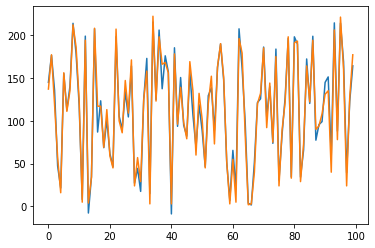

In [24]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)

In [25]:
print(reg.score(X_train,y_train))

0.9639840540839086


Calculons la MSE:

In [26]:
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

147.06980023383733


What interests us is the low RULs so let's compute the MSEl for points with low RULs let's see the MSE for points with RUL <= 20

In [27]:
treshold = 40
sum = 0
count = 0
for i in range(len(y_test)):
  if (y_test[i]<=treshold):
    sum += (y_hat[i]-y_test[i])**2
  count += 1
MSEl = sum/count
print(MSEl)

55.92231209254865


We see that the MSE for points with low RULs is quite better.

Let's try to train the model on points with low RULs:

91.50767949629098


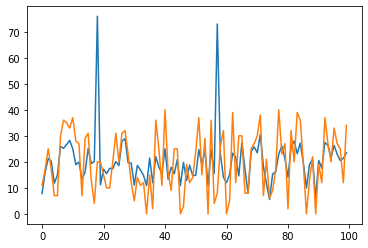

In [28]:
cumulative_onlyLowRul_df = cumulative_df.copy()
cumulative_onlyLowRul_df = cumulative_onlyLowRul_df[cumulative_onlyLowRul_df['RUL'] <= 40]

X_train, X_test, y_train, y_test=train_test_split(cumulative_onlyLowRul_df.drop(['Failure','RUL'], axis=1), cumulative_onlyLowRul_df[['RUL']], test_size=int(0.4*len(cumulative_onlyLowRul_df)))
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
regLow = LinearRegression().fit(X_train,y_train)
y_hat = regLow.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])

MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

The results are worse with only low RULs on the training

Let's try with only the Torque*time:

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
[ 98  66 206 ...  11 216  61]
MSE for Torque, ToolWear and Rpm : 142.3163290614437
[ 98  66 206 ...  11 216  61]
MSE for only Torque and ToolWear : 142.45004778209025
[ 98  66 206 ...  11 216  61]
MSE for only ToolWear : 143.46569539230097


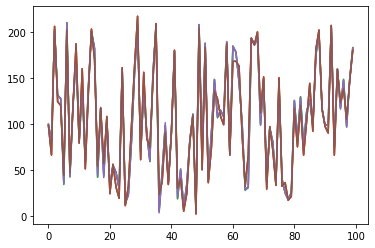

In [29]:

X_train_df, X_test_df, y_train_df, y_test_df=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

Let's take consecutive datas:

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
MSE for Torque, ToolWear and Rpm : 184.3224012454779
MSE for only Torque and ToolWear : 184.64873049237025
MSE for only ToolWear : 184.77552562517306


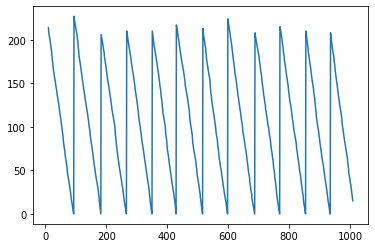

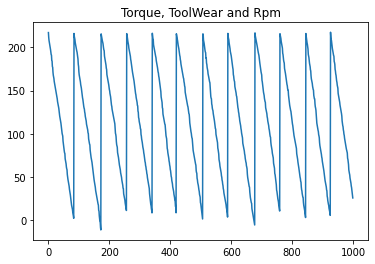

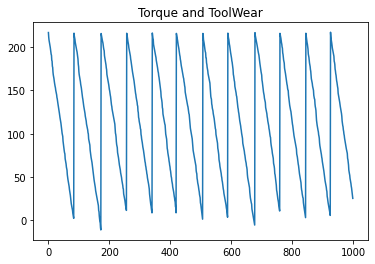

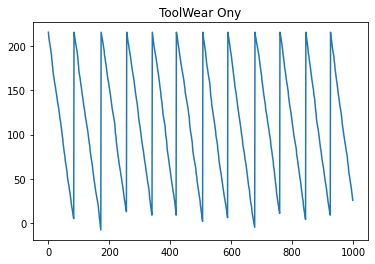

In [32]:

X_train_df, X_test_df, y_train_df, y_test_df=cumulative_df[:6000].drop(['Failure','RUL'], axis=1),cumulative_df[6000:].drop(['Failure','RUL'], axis=1),cumulative_df[['RUL']][:6000],cumulative_df[['RUL']][6000:]
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

aff_len = 1000
abscissas = [i for i in range(aff_len)]
abscissas_shift = [i+10 for i in range(aff_len)]

plt.figure(1)
plt.plot(abscissas_shift,y_test[:aff_len])

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
plt.figure(2)
plt.title("Torque, ToolWear and Rpm")
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)

plt.figure(3)
plt.title("Torque and ToolWear")
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
plt.figure(4)
plt.title("ToolWear Ony")
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

Knn variant, assuming our data is linearly separable
Let's note that with the KNN, it's fairly difficult to use the categorical features so we will stick to the our non categorical features
</br>
Let's start by creating the appropriate dataset , and let's remember the provided attributes in our dataset

In [134]:
list(df.columns)

['UDI',
 'Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF',
 'totalTime']

In [142]:
data_knn = {
    'Torque_Cumu':[0]*9999,
    'Rpm_Cumu':[0]*9999,
    'ToolWear':[0]*9999,
    'Failure':[0]*9999
    
}
cumulative_knn_df = pd.DataFrame(data_knn)
lastChangePoint = 0
cumulative_knn_df['ToolWear'] = df['Tool wear [min]']

for i in range(9999):
  if df['Tool wear [min]'][i] == 0:
    cumulative_knn_df['Torque_Cumu'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
    cumulative_knn_df['Rpm_Cumu'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
  else:
    cumulative_knn_df['Torque_Cumu'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_knn_df['Torque_Cumu'][i-1]
    cumulative_knn_df['Rpm_Cumu'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_knn_df['Rpm_Cumu'][i-1]
  if df['TWF'][i]==1:
    cumulative_knn_df['Failure'][i]=1
  else:
    cumulative_knn_df['Failure'][i]=0


In [143]:
RUL_knn = []

toolChanges = []
for i in range(1,10000):
  if df['Tool wear [min]'][i-1] == 0:
    toolChanges.append(i-2)
iterator = iter(toolChanges)
actual = next(iterator)

for i in range(9999):
  if i > actual:
    actual = next(iterator,9999)
  RUL_knn.append(df['Tool wear [min]'][actual] - df['Tool wear [min]'][i])

# print(toolChanges)

cumulative_knn_df['RUL_knn']=RUL_knn
cumulative_knn_df = cumulative_knn_df[cumulative_knn_df['RUL_knn'] < 40]

Let's now prepare the training and testing sets

In [144]:
cumulative_knn_df.head(80)
cumulative_knn_df.describe()

,Torque_Cumu,Rpm_Cumu,ToolWear,Failure,RUL_knn
count,1892.000000,1892.000000,1892.000000,1892.000000,1892.000000
mean,7889.726744,304633.580338,195.618922,0.024313,19.004228
std,865.321134,31661.845574,20.691154,0.154059,11.805536
min,99.000000,4731.000000,0.000000,0.000000,0.000000
25%,7423.500000,288256.750000,185.000000,0.000000,9.000000
50%,7901.500000,305537.500000,196.000000,0.000000,19.000000
75%,8380.250000,322535.000000,207.000000,0.000000,29.000000
max,10125.000000,392043.000000,253.000000,1.000000,39.000000


Now that our dataset is ready, let's do the splitting

In [145]:
X_knn = cumulative_knn_df.loc[:,cumulative_knn_df.columns != "Failure"]
y_knn = cumulative_knn_df.loc[:,cumulative_knn_df.columns == "Failure"]

X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.30)
# Normalising : 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train


,Failure
3350,0
7760,0
7414,0
6161,0
755,0
...,...
7510,1
5822,0
3020,0
76,0


Splitting and scaling are done, let's train our model

In [146]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
knn_model = KNeighborsClassifier(n_neighbors=5)
print("coucou")
knn_model.fit(X_train, np.ravel(y_train))

y_hat = knn_model.predict(X_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

coucou
[[553   1]
 [ 14   0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       554
           1       0.00      0.00      0.00        14

    accuracy                           0.97       568
   macro avg       0.49      0.50      0.49       568
weighted avg       0.95      0.97      0.96       568



In [147]:
avg_errors = []

# Calculating error for K values between 1 and 40
for i in range(1,40):
    knn_model_comp = KNeighborsClassifier(n_neighbors=i)
    knn_model_comp.fit(X_train, np.ravel(y_train))
    y_hat = knn_model_comp.predict(X_test)
    avg_errors.append(np.mean(np.ravel(y_hat) != np.ravel(y_test)))

Text(0, 0.5, 'Mean Error')

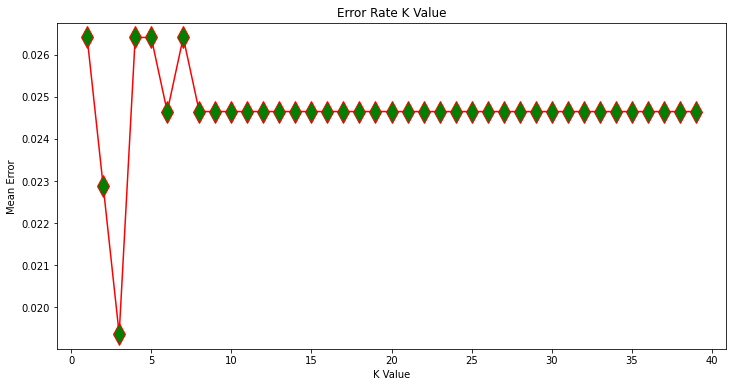

In [148]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), avg_errors, color='red', marker='d', markersize="15", markerfacecolor='green')
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')